### Tree Based Methods

In particular tree based methods require little data preparation.

Also, Random Forest let identift features that are significantly more discriminative than others.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

def get_Titanic_df():
    # Get csv
    df_train = pd.read_csv("../dataset/train.csv")
    df_test = pd.read_csv("../dataset/test.csv")
    dfs = [df_train,df_test]
    for index, df in enumerate(dfs):
        # Data Cleaning
        df = df.drop(columns=['Cabin','Ticket','Name'])
        df  = df.fillna(df_train.mean())
        # Sex binaryzation
        df.loc[df_train['Sex']=='male','Sex'] = 1
        df.loc[df_train['Sex']=='female','Sex'] = 0
        df = df.rename(columns = {'Sex':'Male'})
        dfs[index] = df
    return dfs

# Generate testing Set
def train_test_Titanic(df, test_percent):
    from sklearn.model_selection import train_test_split
    col_names = ['Pclass','Male','Age','SibSp','Parch','Fare','Embarked']
    X = pd.get_dummies(df.loc[:,col_names])
    y = df.loc[:,'Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_percent)
    return X_train, X_test, y_train, y_test

df_train, df_test = get_Titanic_df()
df_train.head()

,PassengerId,Survived,Pclass,Male,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,0,38.0,1,0,71.2833,C
2,3,1,3,0,26.0,0,0,7.9250,S
3,4,1,1,0,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S


In [2]:
df_test.head()

,PassengerId,Pclass,Male,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,Q
1,893,3,0,47.0,1,0,7.0000,S
2,894,2,0,62.0,0,0,9.6875,Q
3,895,3,0,27.0,0,0,8.6625,S
4,896,3,1,22.0,1,1,12.2875,S


## Model 1 - Tree based method: Decision Tree Default

 * Score = 0.73205

In [3]:
## Test 1 Decision Tree
X_train, X_test, y_train, y_test = train_test_Titanic(df_train, 0.25)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini'
                            ,splitter='best'
                            ,random_state=1
                            ,min_impurity_decrease=0
                            #,max_depth=14
                            )

clf.fit(X_train, y_train)

print("DecisionTreeClassifier Accuracy = {0}".format(clf.score(X_test,y_test)))

def get_test_X(df):
    col_names = ['Pclass','Male','Age','SibSp','Parch','Fare','Embarked']
    X = df.loc[:,col_names]
    X = pd.get_dummies(X)
    X.head()
    return X

#### Exporting Results
def exporting_results(clf, filename):
    X_kaggle = get_test_X(df_test)
    y_pred = clf.predict(X_kaggle)
    df = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
    df.head()
    df.to_csv('../results/{0}'.format(filename),index=False)
    return df

df = exporting_results(clf,'python_decisiontree_default.csv')

DecisionTreeClassifier Accuracy = 0.7443946188340808


### Plot Feature Importance

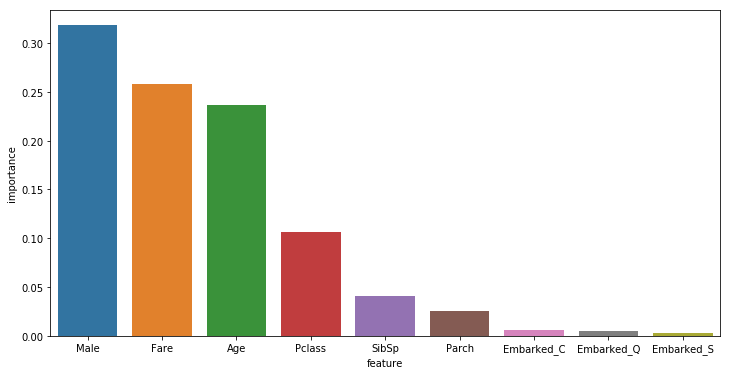

In [4]:
def plot_decisionTree_feature_impiortance(clf):
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig = plt.figure(figsize=(12,6))
    importances = clf.feature_importances_
    df_importances = pd.DataFrame({'feature':X_train.columns.values,'importance':importances})
    df_importances = df_importances.sort_values(by=['importance'],ascending=False)
    sns.barplot(x='feature'
                ,y='importance'
                ,data=df_importances
               )

plot_decisionTree_feature_impiortance(clf)

### Plot main tree

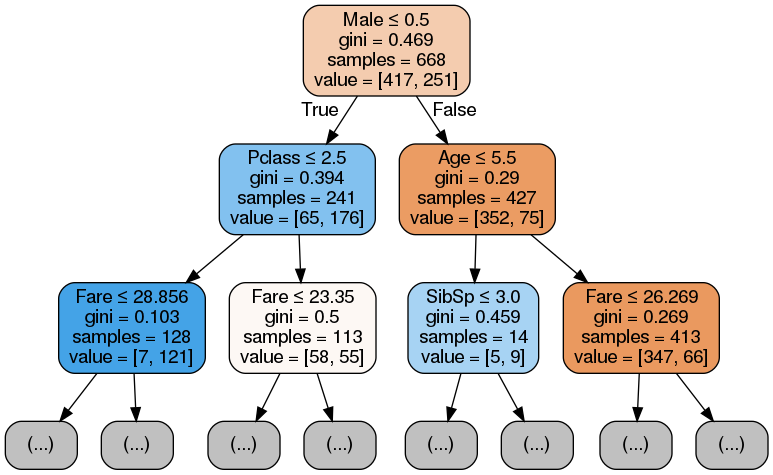

In [5]:
def plot_tree(clf):
    from sklearn.tree import export_graphviz
    import pydotplus
    from IPython.display import Image 
    dot_data = export_graphviz(clf,
                               out_file=None,  
                               filled=True,
                               rounded=True,
                               special_characters=True,
                              feature_names=X_train.columns.values,
                              max_depth=2)
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())
    
plot_tree(clf)

## Model 2 - Tree based method: Decision Tree with Grid Search

 * Score = 0.77990

In [6]:
X_train, X_test, y_train, y_test = train_test_Titanic(df_train, 0)

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion':['gini','entropy']
    ,'max_depth':[2,3,4,5,6,7,8,9,10,50,100]
}

clf = GridSearchCV(DecisionTreeClassifier()
                   ,param_grid
                   ,cv=5 
                   ,scoring='accuracy'
                  )
clf.fit(X_train, y_train)

print('Best Params : {0}'.format(clf.best_params_))
print('Best Score  : {0}'.format(clf.best_score_))

df = exporting_results(clf,'python_decisiontree_GridSearch.csv')

Best Params : {'criterion': 'entropy', 'max_depth': 9}
Best Score  : 0.8249158249158249


## Model 3 - Random Forest

In [19]:
X_train, X_test, y_train, y_test = train_test_Titanic(df_train, 0)

from sklearn.ensemble import RandomForestClassifier


#param_grid = {"max_depth": [None],
#              "max_features": [1, 3, 10],
#              "min_samples_split": [2, 3, 10],
#              "min_samples_leaf": [1, 3, 10],
#              "bootstrap": [False],
#              "n_estimators" :[100,300],
#              "criterion": ["gini"]
#             }

param_grid = { 
    'n_estimators': [100,300],
    'max_features': [1, 3, 10],
    'max_features': ['auto'],
    'min_samples_split': [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    'max_depth' : [None],
    'criterion' :['gini']#, 'entropy']
}

clf = GridSearchCV(RandomForestClassifier()
                   ,param_grid=param_grid
                   ,cv= 5
                   ,scoring='accuracy'
                   ,n_jobs= 4 
                   ,verbose = 1
                  )
clf.fit(X_train, y_train)

print('Best Params : {0}'.format(clf.best_params_))
print('Best Score  : {0}'.format(clf.best_score_))

df = exporting_results(clf,'python_RandomForestClassifier_GridSearch.csv')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    6.7s finished


Best Params : {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
Best Score  : 0.8372615039281706


In [1]:
def plot_randomforest_feature_impiortance(clf):
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig = plt.figure(figsize=(12,6))
    importances = clf.best_estimator_.feature_importances_
    df_importances = pd.DataFrame({'feature':X_train.columns.values,'importance':importances})
    df_importances = df_importances.sort_values(by=['importance'],ascending=False)
    sns.barplot(x='feature'
                ,y='importance'
                ,data=df_importances
               )

plot_randomforest_feature_impiortance(clf)


NameError: name 'clf' is not defined